In [ ]:
!git clone https://github.com/CompVis/attribute-control.git
%cd attribute-control/notebooks
!pip install -q -r ../requirements.txt

In [1]:
import sys

import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

sys.path.append('..')
from attribute_control import EmbeddingDelta
from attribute_control.model import SDXL
from attribute_control.prompt_utils import get_mask, get_mask_regex

torch.set_float32_matmul_precision('high')

DEVICE = 'cuda:0'
DTYPE = torch.float16

In [2]:
model = SDXL(
    pipeline_type='diffusers.StableDiffusionXLPipeline',
    model_name='stabilityai/stable-diffusion-xl-base-1.0',
    pipe_kwargs={ 'torch_dtype': DTYPE, 'variant': 'fp16', 'use_safetensors': True },
    device=DEVICE
)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
delta = EmbeddingDelta(model.dims)
state_dict = torch.load('../pretrained_deltas/person_age.pt')
delta.load_state_dict(state_dict['delta'])
delta = delta.to(DEVICE)

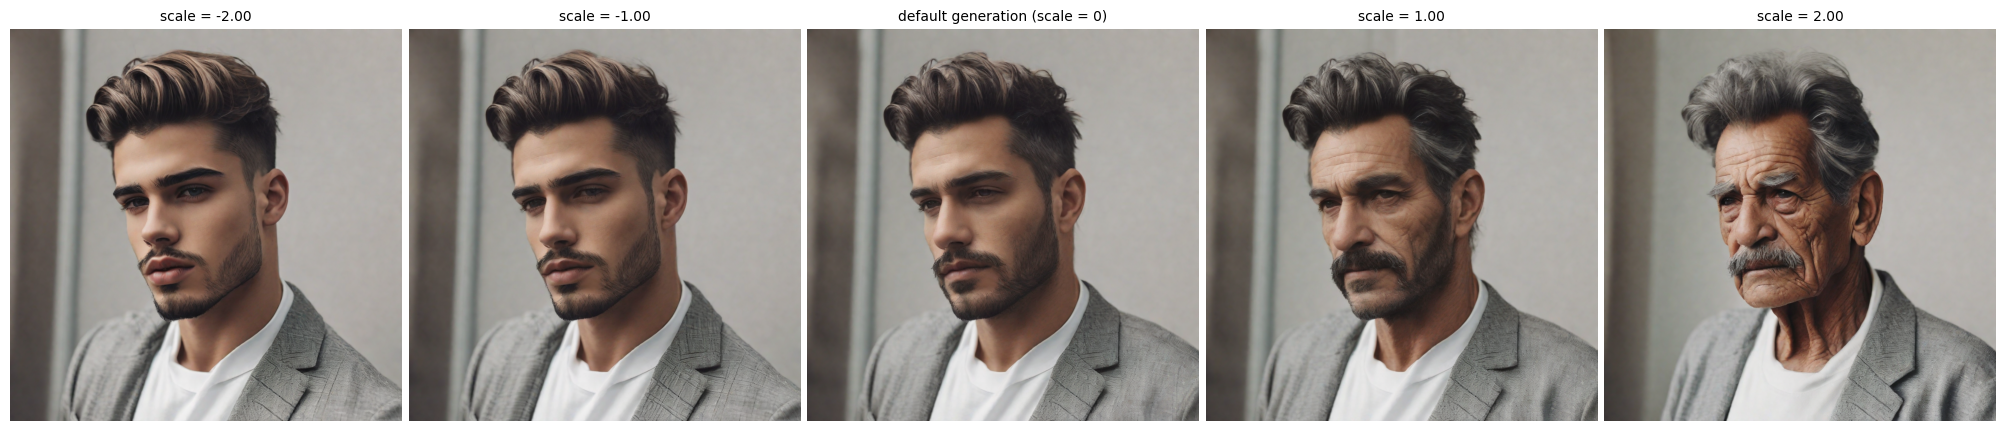

In [4]:
prompt = 'a photo of a beautiful man'
# The delta is applied to this regex pattern in the positive prompt
# If you don't feel comfortable with regex, use get_mask(prompt, target) instead
pattern_target = r'\b(man)\b'
prompt_negative = None # Optional negative prompt
seed = 42
scales = np.linspace(-2, 2, num=5) # [0.0, 1.0]

# Delta application delay
# Set to 0 to apply the delta for the whole sampling process
# Set to something between 0 and 1 to skip applying the delta for the first steps (e.g., first 20% of steps for 0.2)
# If you prefer a minor change to the overall image (e. g., just the face changing when modifying age), set to ~0.2
# If you'd rather want major changes that capture all correlations such as the background changing with age, set to 0.0
delay_relative = 0.20

# Sample from the set of provided scales
characterwise_mask = get_mask_regex(prompt, pattern_target)
emb = model.embed_prompt(prompt)
emb_neg = None if prompt_negative is None else model.embed_prompt(prompt_negative)
imgs = []
for alpha in scales:
    img = model.sample_delayed(
        # Multiple deltas can simply be applied by stacking delta.apply() calls with different deltas
        embs=[delta.apply(emb, characterwise_mask, alpha)],
        embs_unmodified=[emb],
        embs_neg=[emb_neg],
        delay_relative=delay_relative,
        generator=torch.manual_seed(seed),
        guidance_scale=7.5
    )[0]
    imgs.append(img)

    # Display outputs
    clear_output()
    plt.figure(figsize=(max(10, 4 * len(imgs)), 5))
    for i, (alpha, img) in enumerate(zip(scales, imgs, strict=False)):
        plt.subplot(1, len(imgs), i + 1)
        plt.imshow(img)
        plt.title(f'scale = {alpha:.2f}' if alpha != 0 else 'default generation (scale = 0)', fontsize=10)
        plt.axis('off')
    plt.tight_layout(pad=0.5, h_pad=1.0, w_pad=0.5)
    plt.subplots_adjust(top=0.9)
    plt.show()